In [1]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
eqsys = pyequion2.EquilibriumBackend(["C", "Ca", "Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [6]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'C':0.065, 'Ca':0.028, 'Na':0.075, 'Cl':0.056}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Calcite"],
                           kreaction="inf")
builder.make_grid(2, 5)
builder.set_species()

In [7]:
builder.set_initial_guess_from_bulk()

In [8]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [9]:
#min f(x)
#s.t. g(x) = 0
#-------------
#grad f(x) - jac(g)(x)^T \lambda = 0
#g(x) = 0
#h(x, \lambda) = [grad f(x) - jac(g)(x)^T \lambda, g(x)]
#dh(x, \lambd) = [[hess f(x) - -d/dx(jac(g)(x)^T), -jac(g)(x)^T], [jac(g)(x), 0]

In [10]:
builder.simplified = False

def flat_residual(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(logcmu, lma=False, include_mu=False)
    return res.flatten()

def flat_objective(x):
    logcmu = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.gibbs_free_energy(logcmu)
    return res.flatten()[0]
    
def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g

def torch_wrap(f):
    def g(*args):
        args = [torch.tensor(arg, dtype=torch.float) for arg in args]
        res = f(*args).detach().numpy()
        return res
    return g

In [11]:
#min f(x)
#s.t g(x) = 0
# grad f(x) + dg.T(x)@lambd = 0
# g(x) = 0

In [12]:
def make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, nx, nlambd):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = np.concatenate([res1, res2], axis=-1)
        return res
    def jacobian(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        jac11 = d2f(x) - d2g(x, lambd)
        jac12 = -dg(x).T
        jac21 = dg(x)
        jac22 = np.zeros([nlambd, nlambd])
        jac = np.block([[jac11, jac12], [jac21, jac22]])
        return jac
    return residual, jacobian

def make_lagrangian_residual(g, df, dg, nx):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = torch.cat([res1, res2], dim=-1)
        return res
    return residual

In [13]:
f_t = flat_objective
df_t = functorch.jacrev(f_t)
d2f_t = functorch.hessian(f_t)
g_t = flat_residual
dg_t = functorch.jacrev(g_t)
d2g_t = functorch.jacrev(lambda x, v : (dg_t(x).T)@v)
f = torch_wrap(f_t)
df = torch_wrap(df_t)
d2f = torch_wrap(d2f_t)
g = torch_wrap(g_t)
dg = torch_wrap(dg_t)
d2g = torch_wrap(d2g_t)

equality_constraint = scipy.optimize.NonlinearConstraint(
    g, lb=0.0, ub=0.0, jac = dg, hess=d2g)
x0 = builder.x.detach().numpy()
lambd0 = builder.lambd.detach().numpy()
xlambd0 = np.concatenate([x0, lambd0], axis=0)

In [21]:
h, dh = make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, len(builder.x), len(builder.lambd))

In [26]:
# sol = scipy.optimize.minimize(f, x0, jac=df,
#                               constraints=equality_constraint,
#                               hess=d2f,
#                               method='trust-constr')

In [29]:
sol = scipy.optimize.root(h, xlambd0, jac=dh, method="lm")
sol.success

True

In [30]:
sol.x

array([-1.91374337e+01, -2.00989184e+01, -1.00742845e+01, -3.29659610e+00,
       -8.04365675e+00, -1.10630890e+01, -2.66607807e+01, -1.50222600e+01,
       -1.54130614e+01, -3.57612165e+00, -2.30339754e+01, -1.98127567e+01,
       -2.90764248e+00, -2.88240344e+00, -8.55055522e+00, -3.60194689e+00,
       -3.33983736e+01, -1.19152088e+01, -7.11782849e+00, -2.59026806e+00,
       -7.96740786e+00, -2.97128917e+03, -3.91913855e+01, -1.68652529e+01,
       -2.15447933e+01, -1.93949876e+01, -1.59029207e+01, -1.94302415e+02,
       -2.08775470e+03, -8.24981739e+00, -3.07119961e-02, -5.67671353e+01,
        6.12090216e+00, -8.78625734e+01, -3.39908236e-01, -1.43151799e+02,
       -1.75531954e+00, -6.52864971e+01, -1.55009781e-02, -1.77119986e+00])

In [178]:
x = sol.x[:len(builder.x)]

In [179]:
logcmu = x.reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

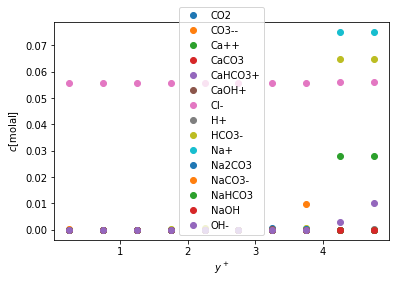

In [180]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

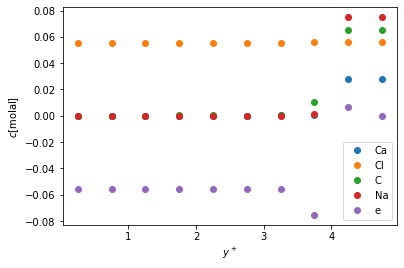

In [181]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

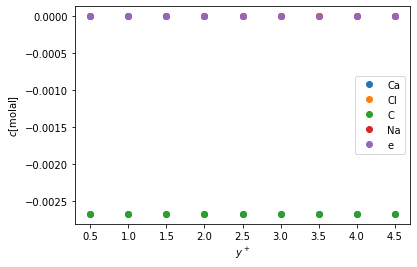

In [182]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [248]:
4/(1e-2)*builder.fluxes()

tensor([[ 6.6646e-06,  8.2600e-06,  5.8769e-06,  5.7761e-06,  4.2858e-06,
         -6.4416e-06, -8.1932e-06,  9.9411e-06,  4.2804e-06, -5.9772e-06,
         -2.1050e-06, -9.8062e-06,  1.1723e-05, -6.5610e-06, -1.3883e-05,
          3.4611e-05,  4.7454e-06,  2.5661e-06, -2.9176e-05,  2.9094e-05,
         -5.0136e-06,  4.7004e-05, -1.1938e-05, -6.7049e-05, -8.9124e-06,
          2.2800e-05,  6.3230e-05, -4.2502e-05, -8.2783e-05,  2.1131e-05,
          8.7177e-05, -1.2582e-04,  1.1556e-04,  1.1245e-04, -1.2851e-04,
          1.5374e-05, -1.1894e-04,  1.0911e-04,  2.9944e-05, -2.4256e-04,
          1.5396e-04,  1.0129e-05, -1.6122e-05,  1.8806e-04,  2.2795e-04,
         -3.5556e-04, -7.9265e-05, -2.2032e-04, -4.1008e-05],
        [-7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01,
         -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8369e-01, -7.8368e-01,
         -7.8369e-01, -7.8368e-01, -7.8369e-01, -7.8368e-01, -7.8369e-01,
         -7.8369e-01, -7.8369e-01, -7.8370e-01, -7